# Used Mnist data set 

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
def plot_image(image):
  plt.imshow(image,cmap='gray',interpolation='nearest')
  plt.axis('off')

def plot_color_image(image):
  plt.imshow(image,interpolation='nearest')
  plt.axis('off')

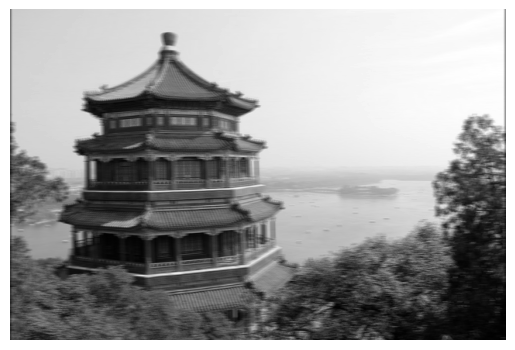

In [3]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') /255
images = np.array([china,flower])
batch_size, height, width, channels = images.shape

# create 2 filters
filters = np.zeros(shape=(7,7,channels,2),dtype=np.float32)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

outputs = tf.nn.conv2d(images,filters,strides=1, padding='SAME')

plt.imshow(outputs[0, :, :, 1], cmap='gray')
plt.axis('off')
plt.show()

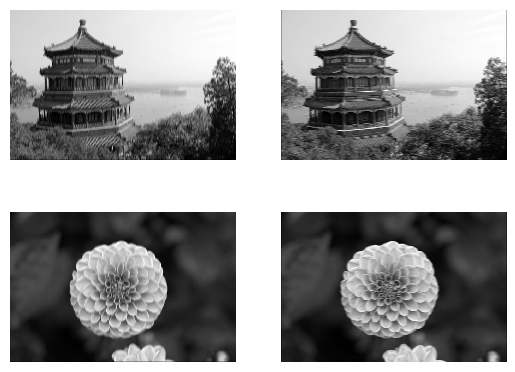

In [4]:
for image_index in (0,1):
  for feature_map_index in (0,1):
    plt.subplot(2,2, image_index * 2 + feature_map_index + 1)
    plot_image(outputs[image_index, :, :, feature_map_index])
plt.show()

In [5]:
def crop(images):
  return images[150:200, 130:250]

Saving figure china_orginal


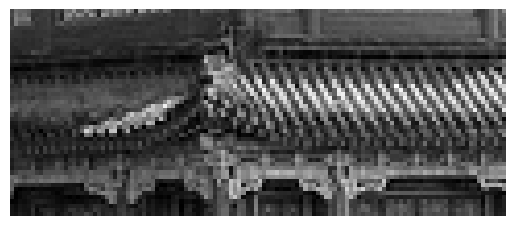

Saving figure china_vertical


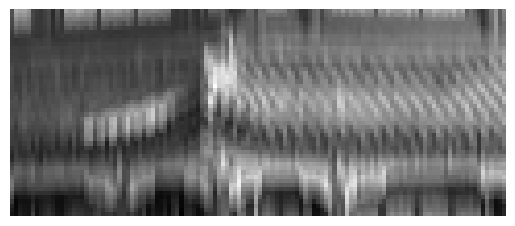

Saving figure china_horizontal


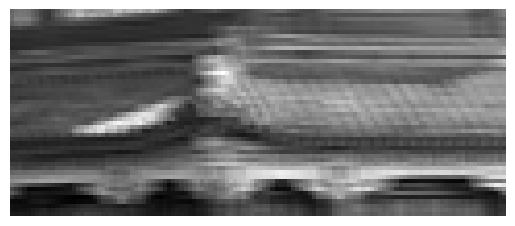

In [6]:
plot_image(crop(images[0,:,:,0]))
save_fig('china_orginal',tight_layout=False)
plt.show()

for feature_map_index,filename in enumerate(["china_vertical", "china_horizontal"]):
  plot_image(crop(outputs[0, :, :, feature_map_index]))
  save_fig(filename, tight_layout=False)
  plt.show()

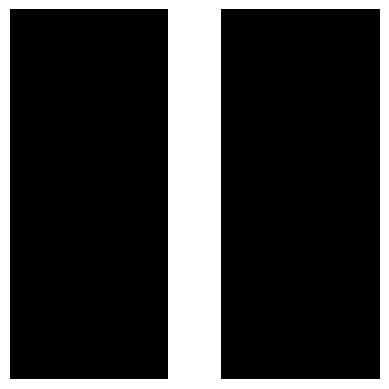

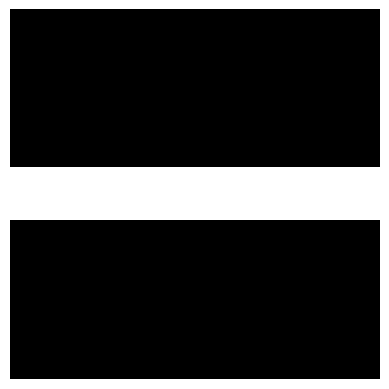

In [7]:
plot_image(filters[:, :, 0, 0])
plt.show()

plot_image(filters[:,:,0,1])
plt.show()

# Convolutional Layer

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2,kernel_size=7,strides=1,
                           padding='SAME',activation='relu',
                           input_shape=outputs.shape)

In [9]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

The output is a 4D tensor. The dimensions are: batch size, height, width, channels. The first dimension (batch size) is 2 since there are 2 input images. The next two dimensions are the height and width of the output feature maps: since `padding="SAME"` and `strides=1`, the output feature maps have the same height and width as the input images (in this case, 427×640). Lastly, this convolutional layer has 2 filters, so the last dimension is 2: there are 2 output feature maps per input image.

Since the filters are initialized randomly, they'll initially detect random pattern. lets take a look at the 2 output features maps for each image:

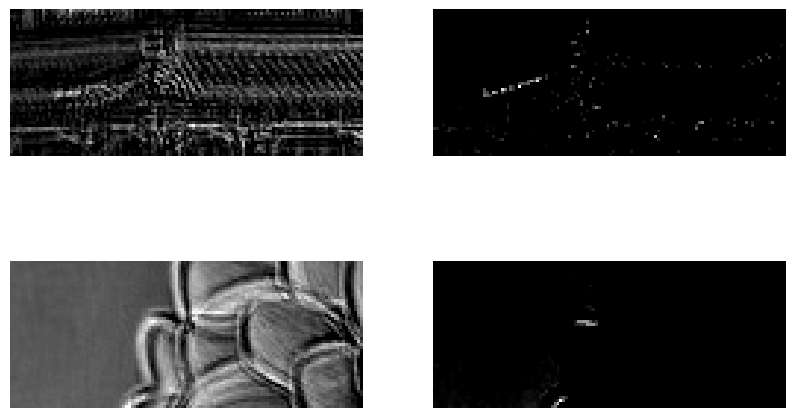

In [10]:
plt.figure(figsize=(10,6))
for image_index in (0,1):
  for feature_map_index in (0,1):
    plt.subplot(2,2, image_index * 2 + feature_map_index + 1)
    plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

In [11]:
conv.set_weights([filters, np.zeros(2)])
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

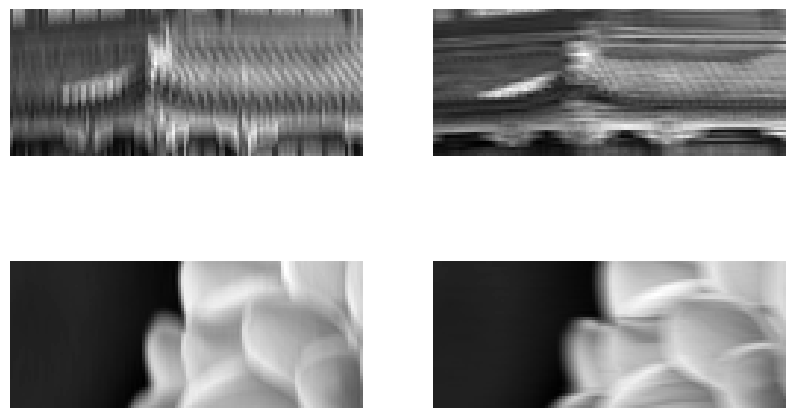

In [12]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

# Valid and same padiing

In [13]:
def feature_map_size(input_size, kernel_size, strides = 1, padding="SAME"):
  if padding =='SAME':
    return (input_size -1 ) // strides + 1
  else :
    return (input_size - kernel_size) // strides + 1

In [14]:
def pad_before_and_padded_size(input_size,kernel_size,strides=1):
  fmap_size = feature_map_size(input_size,kernel_size,strides)
  padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
  pad_before = (padded_size - input_size) // 2
  return pad_before, padded_size

In [15]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

Using 'SAME' padding is equivalent to padding mannually using manual_same_padding() then using valid padding (confusingly,'VALID' padding means no padding at all):

In [16]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1,kernel_size = kernel_size,
                                 strides=strides,padding='VALID')
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, 
                                strides=strides, padding="SAME")


valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

# Pooling layer

# Max Pooling

In [18]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [19]:
cropped_images = np.array([crop(image) for image in images], dtype = np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


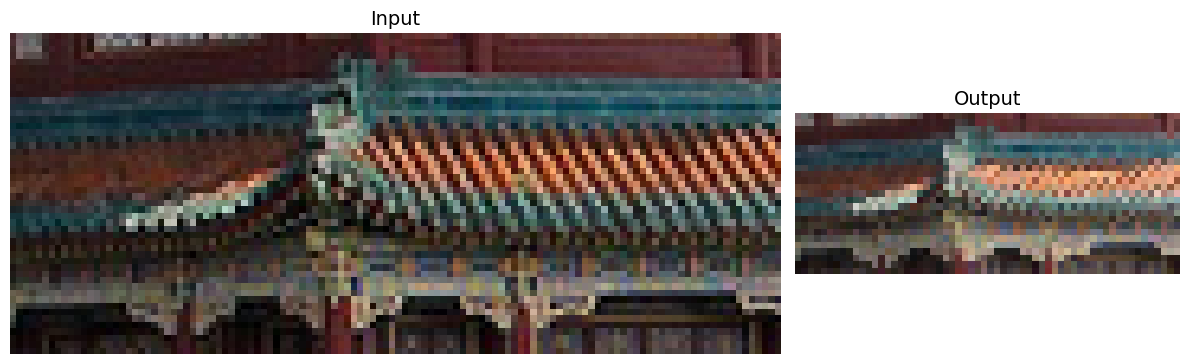

In [20]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

In [21]:
class DepthMaxPool(keras.layers.Layer):
  def __init__(self,pool_size,strides=None,padding='VALID',**kwargs):
    super().__init__(**kwargs)
    if strides is None:
      strides = pool_size
    self.pool_size = pool_size
    self.strides = strides
    self.padding = padding
  def call(self, inputs):
    return tf.nn.max_pool(inputs,
                          ksize=(1,1,1,self.pool_size),
                          strides=(1,1,1,self.pool_size),
                          padding = self.padding)

In [22]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 50, 120, 1])

Or just use a Lambda layer

In [25]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 50, 120, 1])

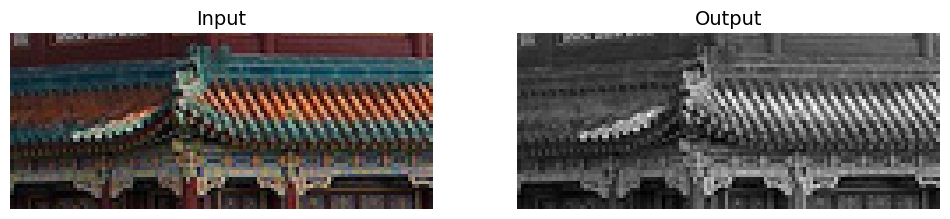

In [26]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

# Average Pooling

In [27]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [28]:
output_avg = avg_pool(cropped_images)

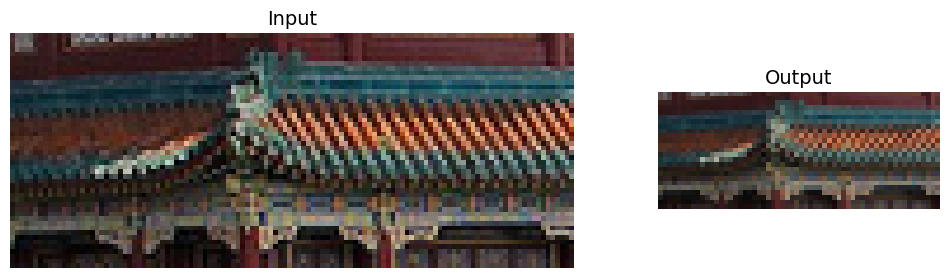

In [29]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [2]:
(X_train_full, y_train_full),(X_test,y_test) =keras.datasets.fashion_mnist.load_data()
X_train,X_valid =X_train_full[:-5000],X_train_full[-5000:]
y_train,y_valid =y_train_full[:-5000],y_train_full[-5000:]

X_mean = X_train.mean(axis=0,keepdims=True)
X_std = X_train.std(axis=0,keepdims=True) + 1e-7

X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) /X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]


4422102/4422102 [==============================] - 0s 0us/step


In [3]:
Model_1 = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu",input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="SAME"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="SAME"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="SAME"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="SAME"),
    keras.layers.MaxPooling2D(pool_size=2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(units=128,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10,activation='softmax')
])

In [4]:
Model_1.compile(loss='sparse_categorical_crossentropy',optimizer='nadam',
                metrics=["accuracy"])

In [5]:
history_1 = Model_1.fit(X_train,y_train,epochs=10,validation_data=(X_valid,y_valid))

Epoch 1/10
1719/1719 [==============================] - 24s 8ms/step - loss: 0.7221 - accuracy: 0.7507 - val_loss: 0.4071 - val_accuracy: 0.8528
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4336 - accuracy: 0.8564 - val_loss: 0.3636 - val_accuracy: 0.8750
Epoch 3/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3776 - accuracy: 0.8745 - val_loss: 0.3336 - val_accuracy: 0.8848
Epoch 4/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3387 - accuracy: 0.8873 - val_loss: 0.3134 - val_accuracy: 0.8930
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3153 - accuracy: 0.8935 - val_loss: 0.3128 - val_accuracy: 0.8918
Epoch 6/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2998 - accuracy: 0.9007 - val_loss: 0.3064 - val_accuracy: 0.8974
Epoch 7/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2860 - accuracy: 0.9031 - val_loss: 0.2959 - val_ac

In [6]:
score = Model_1.evaluate(X_test,y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = Model_1.predict(X_new)

1/1 [==============================] - 0s 197ms/step
